In [1]:
import gym
import numpy as np

import time

In [2]:
import sys
import os

sys.path.append(os.path.abspath('../'))

del sys, os

In [3]:
import matplotlib.pyplot as plt

In [4]:
# LaTeX rendering in graphs
from distutils.spawn import find_executable
if find_executable('latex'):
    plt.rc('text', usetex=True)

plt.rc('font', family='serif')

# High resolution graphs
%config InlineBackend.figure_format = 'retina'

In [5]:
import torch

In [6]:
%reload_ext autoreload
%autoreload 2

In [7]:
import models.rnn as rnns
import models.mlp as mlps
import models.linear as linears
import control.agents as agents
import control.environments as env

In [8]:
from utils.notifications import Slack

In [9]:
import copy

# Setup

In [10]:
environment = env.OverSimplifiedEnvironment(
    environment=gym.make('Breakout-ram-v0'), 
    agent=None,
    verbose=True,
    max_steps=200,
    capacity=5000,
    representation_method='mixed',
    mixed_threshold=10,
    max_tiling=5
)

/anaconda3/envs/rl/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


In [11]:
input_dimension = environment.get_input_dimension()
n_actions = environment.n_actions
print("Input dimension: {}; number of actions: {}".format(input_dimension, n_actions))

Input dimension: 986; number of actions: 3


In [12]:
model = mlps.MLP(input_dimension=input_dimension, 
                 hidden_dimension=400,
                 n_hidden_layers=2,
                 n_actions=n_actions,
                 dropout=.3)
optimiser = torch.optim.Adam(model.parameters(), lr=.001)
agent = agents.DQNAgent(model, optimiser, gamma=1, temperature=1, algorithm='expsarsa', n_actions=n_actions)
environment.agent = agent

In [19]:
print(environment.agent.q(environment.state_representation(environment.environment.reset())))
model.load_state_dict(torch.load('../saved/mixed_mlp/state_dict.pth'))
agent.commit()
print(environment.agent.q(environment.state_representation(environment.environment.reset())))

[0.6417884  0.57499695 0.62076074]
[0.6417884  0.57499695 0.62076074]


# Experiment

## Training

[0.0000000e+00 0.0000000e+00 5.9604645e-08]
[0.6417884 0.6417884 0.6417884 0.6417884 0.6417884 0.6417884 0.6417884
 0.6417884 0.6417884 0.6417884 0.6417884 0.6417884 0.6417884 0.6417884
 0.6417884 0.6417884 0.6417884 0.6417884 0.6417884 0.6417884 0.6417884
 0.6417884 0.6417884 0.6417884 0.6417884 0.6417884 0.6417884 0.6417884
 0.6417884 0.6417884 0.6417884 0.6417884 0.6417884]


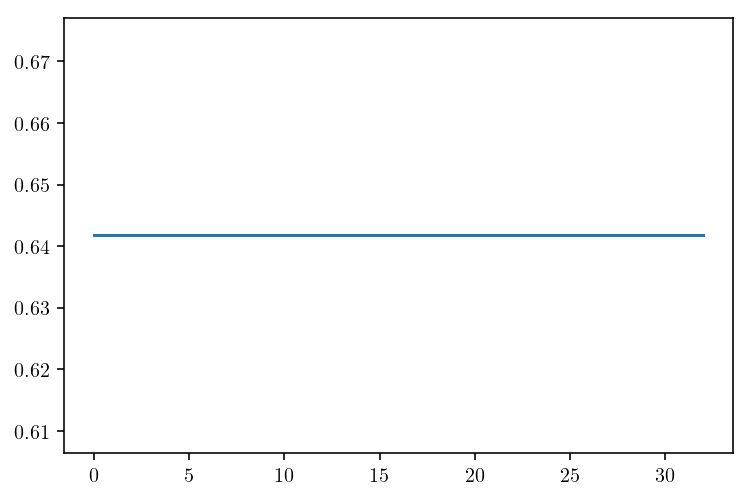

In [22]:
n_episodes = 3
agent.temperature = 0.1

plt.figure()

for i in range(n_episodes):

    full_return, counter, observations = environment.evaluation_episode(render=False,return_observations=True)
    
    q = []
    
    observation_old = None
    q_old = None
    
    for observation in observations:
        
        observation_new = environment.state_representation(observation)
        q_new = environment.agent.q(environment.state_representation(observation))
        
        if observation_old is not None:
            same_obs = np.array_equal(observation_old, observation_new)
            same_q = np.array_equal(q_old, q_new)
            if not same_obs and not same_q:
                print("great")
        
        observation_old = observation_new
        q_old = q_new
        
        q.append(q_new)
        
    q = np.asarray(q)
    print(np.std(q, axis=0))
    print(q[:,0])
    plt.plot(q[:,0], label='0')
    break
    #plt.plot(q[:,1], label='1')
    #plt.plot(q[:,2], label='2')
    
plt.show()

In [15]:
plt.figure()
for i in range(n_episodes):
    x = np.asarray(q_estimation[i])
    plt.plot(x[:,1])

plt.show()

NameError: name 'q_estimation' is not defined

<Figure size 432x288 with 0 Axes>

## Testing

In [23]:
agent.temperature = 0.1
for _ in range(5):
    environment.exploration_episode(render=True)

In [24]:
for _ in range(5):
    environment.evaluation_episode(render=True)